# Complete model function

In [ ]:
!pip install transformers
!pip install torch

In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer
from torchvision import transforms, models
from PIL import Image
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, model_name):
        super(ImageEncoder, self).__init__()
        self.model = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])

    def forward(self, image_batch):
        # Reshape the input to (batch_size, 3, 224, 224)
        image_batch = image_batch.view(-1, 3, 224, 224)
        # Encode the images using ResNet50
        image_features = self.model(image_batch)
        # Reshape to (batch_size, 2048, 49)
        image_features = image_features.view(image_features.size(0), 2048, -1)
        return image_features

class TextEncoder(nn.Module):
    def __init__(self, model_name, max_sequence_length):
        super(TextEncoder, self).__init__()
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.text_encoder = DistilBertModel.from_pretrained(model_name)
        self.max_sequence_length = max_sequence_length

    def forward(self, text_batch):
        # Tokenize and ensure the text has a fixed length of max_sequence_length
        text_encoded = self.tokenizer(text_batch, padding='max_length', truncation=True, max_length=self.max_sequence_length, return_tensors="pt")

        # Encode the text using DistilBERT
        text_output = self.text_encoder(**text_encoded)

        # Extract embeddings for all tokens (last_hidden_state)
        text_embeddings = text_output.last_hidden_state  # This will have shape (batch_size, max_sequence_length, hidden_size)

        return text_embeddings

# Define the ProjectionHead class
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=512,  # Update the projection dimension
        dropout=0.1
    ):
        super(ProjectionHead, self).__init__()  # Correct usage of super()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected #skip connection
        x = self.layer_norm(x) #Layer Normalization
        return x

# Cross-Attention module
class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttentionLayer, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.multihead_atten = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, image_features, text_features):
        key = text_features
        value = text_features
        query = image_features
        attn_output, attn_output_weights = self.multihead_atten(query, key, value)
        return attn_output, attn_output_weights

#cosine similarity
def cosine_similarity(avg_attn_out, avg_text_embed):
    dim = len(avg_attn_out)
    similarity_matrix = torch.zeros(dim, dim)
    for i in range(dim):
        for j in range(dim):
            similarity = F.cosine_similarity(avg_attn_out[i], avg_text_embed[j], dim=0)
            similarity_matrix[i, j] = similarity
    return similarity_matrix

#model
class ImageTextMatchingModel(nn.Module):
    def __init__(self, image_encoder, text_encoder, image_projection_head, text_projection_head, cross_attention_layer):
        super(ImageTextMatchingModel, self).__init__()
                # Freeze the parameters of the pretrained image encoder
        for param in image_encoder.parameters():
            param.requires_grad = False

        # Freeze the parameters of the pretrained text encoder
        for param in text_encoder.parameters():
            param.requires_grad = False

        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.image_projection_head = image_projection_head
        self.text_projection_head = text_projection_head
        self.cross_attention_layer = cross_attention_layer

    def forward(self, image_batch, text_batch):
        # Encode images and texts
        image_features = self.image_encoder(image_batch)
        text_embeddings = self.text_encoder(text_batch)
        image_features = image_features.permute(0, 2, 1)
        # Project images and texts
        projected_images = self.image_projection_head(image_features)
        projected_texts = self.text_projection_head(text_embeddings)
        # Cross-attention
        attn_output, attn_output_weights = self.cross_attention_layer(projected_images.permute(1, 0, 2), projected_texts.permute(1, 0, 2))
        attn_output = attn_output.permute(1, 0, 2)
        '''
        # Average pooling for image output
        avg_pool = nn.AdaptiveAvgPool1d(1)
        avg_attn_output = avg_pool(attn_output.permute(0, 2, 1))
        avg_attn_output = avg_attn_output.squeeze(dim=2)
        # CLS pooling for text output
        cls_embeddings = projected_texts[:, 0, :]
        '''

        avg_attn_output = torch.mean(attn_output, dim=1)
        cls_embeddings = torch.mean(projected_texts, dim=1)


        # Compute the cosine similarity score
        score = cosine_similarity(avg_attn_output, cls_embeddings)
        #print("Score",score)
        return score, attn_output, attn_output_weights, avg_attn_output, cls_embeddings, projected_texts#------------------editted----------attn_output, attn_output_weights


In [ ]:
def ContrastiveLoss(text_embeddings,image_embeddings):
        temperature = 1
        logits = (text_embeddings @ image_embeddings.T) / temperature
        #print(logits)
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        #print(loss)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()


In [ ]:
# Create an instance of the ImageTextMatchingModel
image_encoder = ImageEncoder("resnet50")
max_sequence_length = 30
text_encoder = TextEncoder("distilbert-base-uncased", max_sequence_length)
image_projection_head = ProjectionHead(2048)
text_projection_head = ProjectionHead(768)
embedding_dim = 512
cross_aatn = CrossAttentionLayer(embedding_dim, num_heads=4)

model = ImageTextMatchingModel(
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    image_projection_head=image_projection_head,
    text_projection_head=text_projection_head,
    cross_attention_layer=cross_aatn
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Pass  image_batch and text_batch to the model to get the score
image_paths = ['/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/dog.jpg', '/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/cat.jpg', '/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/aeroplane.jpg', '/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/house.jpg']
transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()])
image_batch = torch.stack([transform(Image.open(image_path)) for image_path in image_paths])
text_batch =  ["Dog sit on grass land", "cat sit on bed", "aeroplane fly in the sky", "house"]
score, attn_output, attn_output_weights, avg_attn_output, cls_embeddings, projected_texts = model(image_batch, text_batch)
print(score)

tensor([[-0.1083, -0.1139, -0.0722, -0.0692],
        [-0.1269, -0.1396, -0.0890, -0.0956],
        [-0.0654, -0.0569, -0.0228, -0.0100],
        [-0.0666, -0.0672, -0.0442, -0.0154]], grad_fn=<CopySlices>)


In [ ]:
# Count number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 3020800


# Train

In [ ]:
import logging
import os
import re
from string import punctuation
import itertools
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import DistilBertTokenizer
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

if torch.cuda.is_available():
    model = ImageTextMatchingModel(
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    image_projection_head=image_projection_head,
    text_projection_head=text_projection_head,
    cross_attention_layer=cross_aatn
)
    model = model.to(
        "cuda:0"
    )
    for param in model.parameters():
        param.to("cuda:0")
else:
    model = ImageTextMatchingModel(
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    image_projection_head=image_projection_head,
    text_projection_head=text_projection_head,
    cross_attention_layer=cross_aatn
)
    print("GPU is not available. Using CPU.")

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total learnable parameters: {total_params}")

Using cpu device
GPU is not available. Using CPU.
Total learnable parameters: 3020800


In [ ]:
def clean_text(row):
    regex = re.compile("[%s]" % re.escape(punctuation))
    row = str(row).strip()
    row = row.lower()
    return regex.sub("", row)


BATCH_SIZE = 4
IMG_DIR = "/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/flickr30k_images/flickr30k_images"
IMG_SIZE = 224
captions = pd.read_csv("/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/flickr30k_images/results.csv", sep="|")

def clean_text(row):
    regex = re.compile("[%s]" % re.escape(punctuation))
    row = str(row).strip()
    row = row.lower()
    return regex.sub("", row)

class InvalidDatasetException(Exception):
    def __init__(self, len_of_paths, len_of_labels):
        super().__init__( f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})")

class CustomData(Dataset):
    def __init__(self, img_paths, caps):
        self.img_paths = [os.path.join(IMG_DIR, path) for path in img_paths]
        self.caps = caps
        self.transforms = transforms.Compose([transforms.Resize(size=(IMG_SIZE, IMG_SIZE)), ToTensor()] )
        if len(self.img_paths) != len(self.caps):
            raise InvalidDatasetException(self.img_paths, self.caps)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        tensor_img = self.transforms(img)
        label = self.caps[idx]
        return tensor_img, label


captions.columns = [col.strip() for col in captions.columns]
captions["comment"] = captions["comment"].apply(clean_text)
captions = captions.head(2000)#considering 100 examples
train_captions, val_captions = train_test_split(captions, train_size=0.8, random_state=42)


TRAIN_PATHS = list(train_captions["image_name"])
TEST_PATHS = list(val_captions["image_name"])

train_set = CustomData(TRAIN_PATHS, [statement for statement in train_captions["comment"]])
print(f"The number of images in the train set is : {train_set.__len__()}")

val_set = CustomData(TEST_PATHS, [statement for statement in val_captions["comment"]])
print(f"The number of images in the val set is : {val_set.__len__()}")

torch.manual_seed(42)
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
print( f"the size of the train dataloader {len(train_loader)} batches of {BATCH_SIZE}")

torch.manual_seed(42)
valid_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False)
print(f"the size of the test dataloader {len(valid_loader)} batches of {BATCH_SIZE}")


The number of images in the train set is : 1600
The number of images in the val set is : 400
the size of the train dataloader 400 batches of 4
the size of the test dataloader 100 batches of 4


In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        image, caption = batch
        image = image.to(device)
        score = model(image, caption)
        loss = ContrastiveLoss(score[4], score[3])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()
        count = image.size(0)
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        image, caption = batch
        image = image.to(device)
        score = model(image, caption)
        loss = ContrastiveLoss(score[4], score[3])
        count = image.size(0)
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


In [ ]:
def main():
    model = ImageTextMatchingModel(
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    image_projection_head=image_projection_head,
    text_projection_head=text_projection_head,
    cross_attention_layer=cross_aatn
)
    model = model.to(device)
    for param in model.parameters():
        param.to(device)

    optimizer = Adam(model.parameters(), lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=1, factor=0.1
    )
    best_loss = float('inf')
    for epoch in range(8):  # Adjust the number of epochs as needed
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step="epoch")
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/best_b4_freeze_clip.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

if __name__ == "__main__":
    main()

Epoch: 1


100%|██████████| 100/100 [02:00<00:00,  1.20s/it, valid_loss=3.73]


Saved Best Model!
Epoch: 2


100%|██████████| 100/100 [02:01<00:00,  1.22s/it, valid_loss=4.8]


Epoch: 3


100%|██████████| 100/100 [01:55<00:00,  1.16s/it, valid_loss=1.84]


Saved Best Model!
Epoch: 4


100%|██████████| 100/100 [01:57<00:00,  1.18s/it, valid_loss=2.09]


Epoch: 5


100%|██████████| 100/100 [01:56<00:00,  1.17s/it, valid_loss=1.26]


Saved Best Model!
Epoch: 6


100%|██████████| 100/100 [01:56<00:00,  1.17s/it, valid_loss=7.85]


Epoch: 7


100%|██████████| 100/100 [01:58<00:00,  1.18s/it, valid_loss=12.5]


Epoch: 8


100%|██████████| 100/100 [01:56<00:00,  1.16s/it, valid_loss=3.35]


# Test Inference

In [ ]:
# Create an instance of the model
model = ImageTextMatchingModel(
    image_encoder=image_encoder,
    text_encoder=text_encoder,
    image_projection_head=image_projection_head,
    text_projection_head=text_projection_head,
    cross_attention_layer=cross_aatn
)
image_captioning_model = model
model_path = '/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/best_b4_freeze_clip.pt'
#model_path = "/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/model_epoch_90.pt"
image_captioning_model.load_state_dict(torch.load(model_path, map_location='cpu'))
image_captioning_model.eval()

ImageTextMatchingModel(
  (image_encoder): ImageEncoder(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(

In [ ]:
#Inference for batch of 4 image text pair
from transformers import BertTokenizer
t1 = "A man in a blue shirt is standing on a ladder cleaning a window."
t2 = "A trendy girl talking on her cellphone while gliding slowly down the street. "
t3 = "Five people are sitting in a circle with instruments."
t4 = "A man with a black shirt giving another man a tattoo."
statements = [t1,t2,t3,t4]

# Define image preprocessing transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

im1 = "/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/flickr30k_images/flickr30k_images/1000344755.jpg"
im2 = "/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/flickr30k_images/flickr30k_images/10010052.jpg"
im3 = "/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/flickr30k_images/flickr30k_images/1003420127.jpg"
im4 = "/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/flickr30k_images/flickr30k_images/100577935.jpg"
image_paths = [im1, im2, im3, im4]
images = []
for image_path in image_paths:
    image = Image.open(image_path)
    image = image_transform(image)
    images.append(image)
# Stack the images into a single tensor
images = torch.stack(images)
#images = images.to("cuda:0")
# Make predictions
with torch.no_grad():
    #output = image_captioning_model(images, statements)
    output, atth_out_train, attn_weight_train,avg_attn_output, cls_embeddings, txt_embed = image_captioning_model(images, statements)#----------for edited model
print(output)

tensor([[0.4378, 0.4366, 0.4382, 0.4375],
        [0.4306, 0.4296, 0.4309, 0.4306],
        [0.4332, 0.4320, 0.4334, 0.4331],
        [0.4319, 0.4309, 0.4323, 0.4319]])


In [ ]:
print(atth_out_train.shape)#output image embedding [4, 49, 512]
print(atth_out_train)

torch.Size([4, 49, 512])
tensor([[[ 0.5716, -2.7740,  2.2916,  ...,  8.3372,  3.1691, -0.7891],
         [ 0.5716, -2.7740,  2.2916,  ...,  8.3372,  3.1691, -0.7891],
         [ 0.5716, -2.7740,  2.2916,  ...,  8.3372,  3.1691, -0.7891],
         ...,
         [ 0.5716, -2.7740,  2.2916,  ...,  8.3372,  3.1691, -0.7891],
         [ 0.5716, -2.7740,  2.2916,  ...,  8.3372,  3.1691, -0.7891],
         [ 0.5716, -2.7740,  2.2916,  ...,  8.3372,  3.1691, -0.7891]],

        [[ 0.8875, -2.4871,  2.0853,  ...,  8.2491,  3.1244, -0.3630],
         [ 0.8875, -2.4871,  2.0853,  ...,  8.2491,  3.1244, -0.3630],
         [ 0.8875, -2.4871,  2.0853,  ...,  8.2491,  3.1244, -0.3630],
         ...,
         [ 0.8875, -2.4871,  2.0853,  ...,  8.2491,  3.1244, -0.3630],
         [ 0.8875, -2.4871,  2.0853,  ...,  8.2491,  3.1244, -0.3630],
         [ 0.8875, -2.4871,  2.0853,  ...,  8.2491,  3.1244, -0.3630]],

        [[ 0.8030, -3.5976,  3.0421,  ...,  9.5743,  3.4622, -0.5288],
         [ 0.8030, -

In [ ]:
print(attn_weight_train.shape)#map of each text tokens with each features
print(attn_weight_train)

torch.Size([4, 49, 30])
tensor([[[1.0000e+00, 9.8200e-20, 1.9835e-28,  ..., 4.1603e-28,
          1.6439e-29, 5.0736e-30],
         [1.0000e+00, 9.8024e-20, 1.9873e-28,  ..., 4.1746e-28,
          1.6491e-29, 5.0874e-30],
         [1.0000e+00, 9.5500e-20, 1.9099e-28,  ..., 4.0117e-28,
          1.5818e-29, 4.8765e-30],
         ...,
         [1.0000e+00, 9.9561e-20, 2.0341e-28,  ..., 4.2724e-28,
          1.6900e-29, 5.2150e-30],
         [1.0000e+00, 9.9299e-20, 2.0293e-28,  ..., 4.2642e-28,
          1.6863e-29, 5.2028e-30],
         [1.0000e+00, 9.8738e-20, 2.0172e-28,  ..., 4.2418e-28,
          1.6766e-29, 5.1712e-30]],

        [[1.0000e+00, 3.9481e-24, 1.1585e-27,  ..., 2.0766e-27,
          1.8731e-26, 6.0106e-26],
         [1.0000e+00, 4.0152e-24, 1.1795e-27,  ..., 2.1142e-27,
          1.9060e-26, 6.1179e-26],
         [1.0000e+00, 4.0859e-24, 1.2020e-27,  ..., 2.1546e-27,
          1.9411e-26, 6.2313e-26],
         ...,
         [1.0000e+00, 3.9818e-24, 1.1716e-27,  ..., 2.0

In [ ]:
# Pass  image_batch and text_batch to the model to get the score
image_paths = ['/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/dog.jpg', '/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/cat.jpg', '/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/aeroplane.jpg', '/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/house.jpg']
transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()])
image_batch = torch.stack([transform(Image.open(image_path)) for image_path in image_paths])
text_batch =  ["Dog sit on grass land", "cat sit on bed", "aeroplane fly in the sky", "house"]
score, atth_out, attn_weight,avg_attn_output, cls_embeddings, txt_embedd = image_captioning_model(image_batch, text_batch)#-------------for edited model
print(score)

tensor([[0.4292, 0.4294, 0.4293, 0.4291],
        [0.4261, 0.4264, 0.4264, 0.4264],
        [0.4186, 0.4188, 0.4190, 0.4184],
        [0.4108, 0.4111, 0.4116, 0.4111]], grad_fn=<CopySlices>)


In [ ]:
atth_out#image embedding

tensor([[[ 0.8743, -3.6249,  3.0852,  ...,  9.7482,  3.4176, -0.4338],
         [ 0.8743, -3.6249,  3.0852,  ...,  9.7482,  3.4176, -0.4338],
         [ 0.8743, -3.6249,  3.0852,  ...,  9.7482,  3.4176, -0.4338],
         ...,
         [ 0.8743, -3.6249,  3.0852,  ...,  9.7482,  3.4176, -0.4338],
         [ 0.8743, -3.6249,  3.0852,  ...,  9.7482,  3.4176, -0.4338],
         [ 0.8743, -3.6249,  3.0852,  ...,  9.7482,  3.4176, -0.4338]],

        [[ 0.9972, -3.1146,  2.6560,  ...,  9.1835,  3.3165, -0.2442],
         [ 0.9972, -3.1146,  2.6560,  ...,  9.1835,  3.3165, -0.2442],
         [ 0.9972, -3.1146,  2.6560,  ...,  9.1835,  3.3165, -0.2442],
         ...,
         [ 0.9972, -3.1146,  2.6560,  ...,  9.1835,  3.3165, -0.2442],
         [ 0.9972, -3.1146,  2.6560,  ...,  9.1835,  3.3165, -0.2442],
         [ 0.9972, -3.1146,  2.6560,  ...,  9.1835,  3.3165, -0.2442]],

        [[ 1.1227, -4.8406,  4.2143,  ..., 11.5292,  3.7977, -0.2143],
         [ 1.1227, -4.8406,  4.2143,  ..., 11

In [ ]:
attn_weight

tensor([[[1.0000e+00, 6.3612e-23, 4.5914e-33,  ..., 3.0980e-30,
          1.5209e-29, 8.1839e-31],
         [1.0000e+00, 6.7403e-23, 5.0052e-33,  ..., 3.3527e-30,
          1.6421e-29, 8.8653e-31],
         [1.0000e+00, 7.2814e-23, 5.6216e-33,  ..., 3.7302e-30,
          1.8210e-29, 9.8738e-31],
         ...,
         [1.0000e+00, 4.7643e-23, 2.9495e-33,  ..., 2.0620e-30,
          1.0277e-29, 5.4374e-31],
         [1.0000e+00, 4.9093e-23, 3.0915e-33,  ..., 2.1539e-30,
          1.0713e-29, 5.6772e-31],
         [1.0000e+00, 5.1632e-23, 3.3387e-33,  ..., 2.3120e-30,
          1.1469e-29, 6.0961e-31]],

        [[1.0000e+00, 7.3892e-23, 1.1223e-32,  ..., 2.1683e-30,
          1.6867e-32, 6.3709e-33],
         [1.0000e+00, 8.2173e-23, 1.2912e-32,  ..., 2.4718e-30,
          1.9327e-32, 7.3056e-33],
         [1.0000e+00, 8.5158e-23, 1.3595e-32,  ..., 2.5920e-30,
          2.0322e-32, 7.6860e-33],
         ...,
         [1.0000e+00, 7.5110e-23, 1.1581e-32,  ..., 2.2279e-30,
          1.740

In [ ]:
print(avg_attn_output.shape)# input image embedding for cosine similarity
print(avg_attn_output)

torch.Size([4, 512])
tensor([[ 0.8743, -3.6249,  3.0852,  ...,  9.7482,  3.4176, -0.4338],
        [ 0.9972, -3.1146,  2.6560,  ...,  9.1835,  3.3165, -0.2442],
        [ 1.1227, -4.8406,  4.2143,  ..., 11.5292,  3.7977, -0.2143],
        [ 1.3297, -4.3637,  3.8017,  ..., 11.1199,  3.7215,  0.0877]],
       grad_fn=<MeanBackward1>)


In [ ]:
print(cls_embeddings.shape)# input text embedding for cosine similarity
print(cls_embeddings)

torch.Size([4, 512])
tensor([[ 0.2741, -1.5054,  0.5882,  ...,  0.5870,  2.8979, -1.5910],
        [ 0.2676, -1.4426,  0.6049,  ...,  0.5719,  2.7251, -1.5208],
        [ 0.2348, -1.5130,  0.5734,  ...,  0.5717,  2.8610, -1.5399],
        [ 0.2219, -1.4455,  0.5540,  ...,  0.6120,  2.9367, -1.5365]],
       grad_fn=<MeanBackward1>)


In [ ]:
attn_mapping = attn_weight

In [ ]:
attn_mapping

tensor([[[1.0000e+00, 6.3612e-23, 4.5914e-33,  ..., 3.0980e-30,
          1.5209e-29, 8.1839e-31],
         [1.0000e+00, 6.7403e-23, 5.0052e-33,  ..., 3.3527e-30,
          1.6421e-29, 8.8653e-31],
         [1.0000e+00, 7.2814e-23, 5.6216e-33,  ..., 3.7302e-30,
          1.8210e-29, 9.8738e-31],
         ...,
         [1.0000e+00, 4.7643e-23, 2.9495e-33,  ..., 2.0620e-30,
          1.0277e-29, 5.4374e-31],
         [1.0000e+00, 4.9093e-23, 3.0915e-33,  ..., 2.1539e-30,
          1.0713e-29, 5.6772e-31],
         [1.0000e+00, 5.1632e-23, 3.3387e-33,  ..., 2.3120e-30,
          1.1469e-29, 6.0961e-31]],

        [[1.0000e+00, 7.3892e-23, 1.1223e-32,  ..., 2.1683e-30,
          1.6867e-32, 6.3709e-33],
         [1.0000e+00, 8.2173e-23, 1.2912e-32,  ..., 2.4718e-30,
          1.9327e-32, 7.3056e-33],
         [1.0000e+00, 8.5158e-23, 1.3595e-32,  ..., 2.5920e-30,
          2.0322e-32, 7.6860e-33],
         ...,
         [1.0000e+00, 7.5110e-23, 1.1581e-32,  ..., 2.2279e-30,
          1.740

In [ ]:
attn_mapping.shape

torch.Size([4, 49, 30])

torch.Size([30, 7, 7])


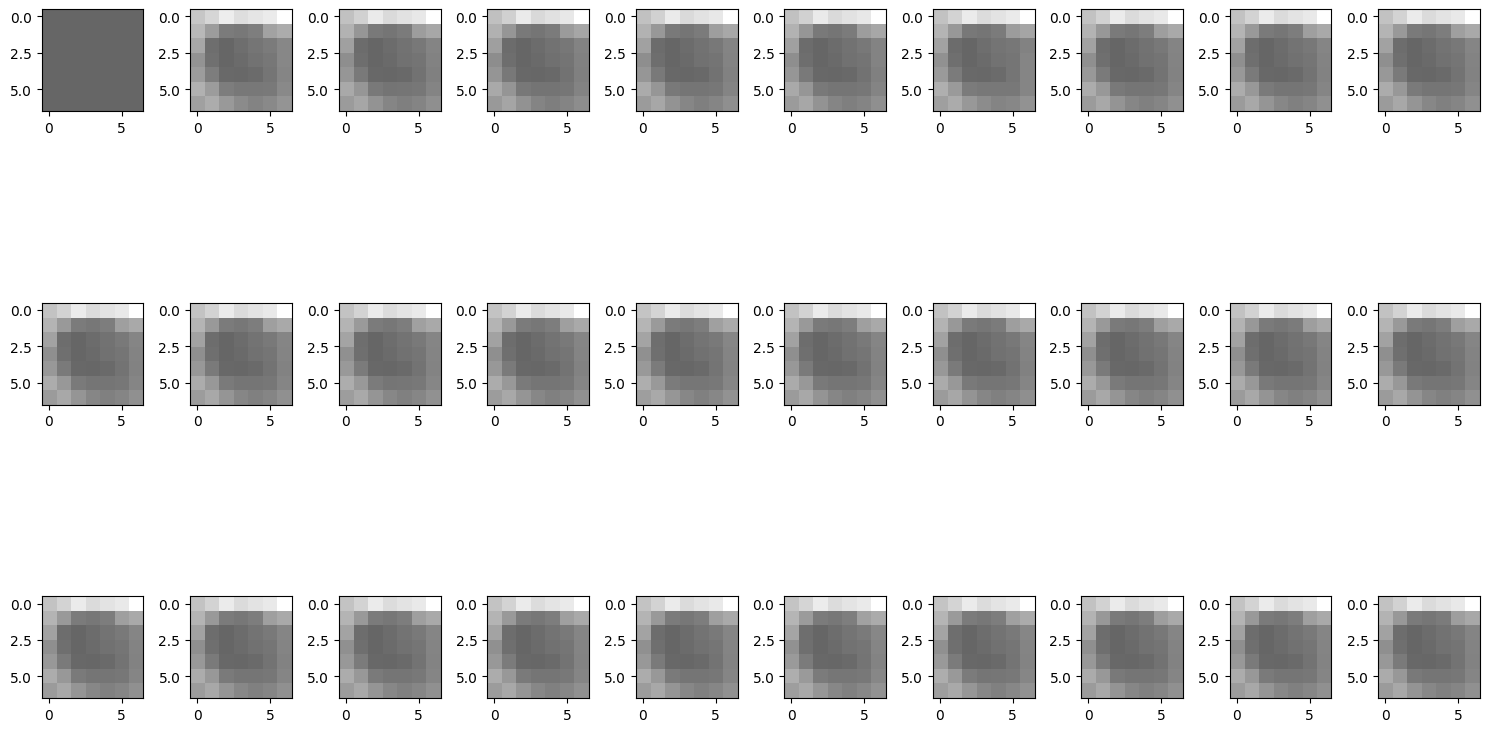

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Assuming attn_maps is a PyTorch tensor with shape [ 30,7,7]
attn_sc = attn_mapping[0].cpu()
attn_maps = attn_sc.permute(1,0)
# Reshape attn_maps to [30,(7, 7)]
attn_maps = attn_maps.view(30, 7, 7)
print(attn_maps.shape)
def plot_attention_maps( attention_map):
    fig = plt.figure(figsize=(15, 10))
    len_result = 30
    titles = []
    for i in range(len_result):
        map = attention_map[i]
        grid_size = max(int(np.ceil(len_result / 3)), 3)
        ax = fig.add_subplot(3, grid_size, i + 1)
        ax.imshow(map, cmap='gray', alpha=0.6)
    plt.tight_layout()

plot_attention_maps(attn_maps.detach().numpy())
plt.show()


torch.Size([30, 7, 7])


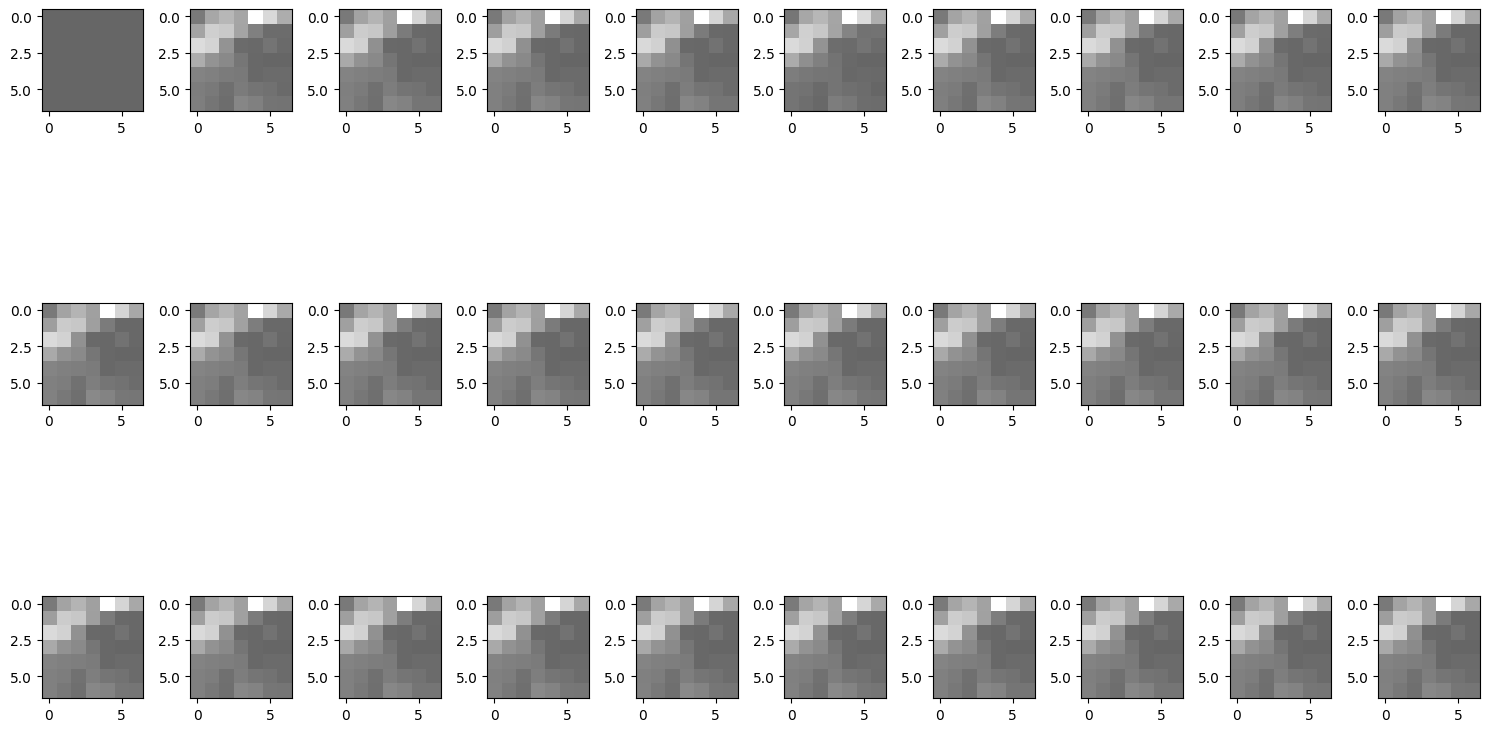

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Assuming attn_maps is a PyTorch tensor with shape [ 30,7,7]
attn_sc = attn_mapping[1].cpu()
attn_maps = attn_sc.permute(1,0)
# Reshape attn_maps to [30,(7, 7)]
attn_maps = attn_maps.view(30, 7, 7)
print(attn_maps.shape)
def plot_attention_maps( attention_map):
    fig = plt.figure(figsize=(15, 10))
    len_result = 30
    titles = []
    for i in range(len_result):
        map = attention_map[i]
        grid_size = max(int(np.ceil(len_result / 3)), 3)
        ax = fig.add_subplot(3, grid_size, i + 1)
        ax.imshow(map, cmap='gray', alpha=0.6)
    plt.tight_layout()

plot_attention_maps(attn_maps.detach().numpy())
plt.show()


torch.Size([30, 7, 7])


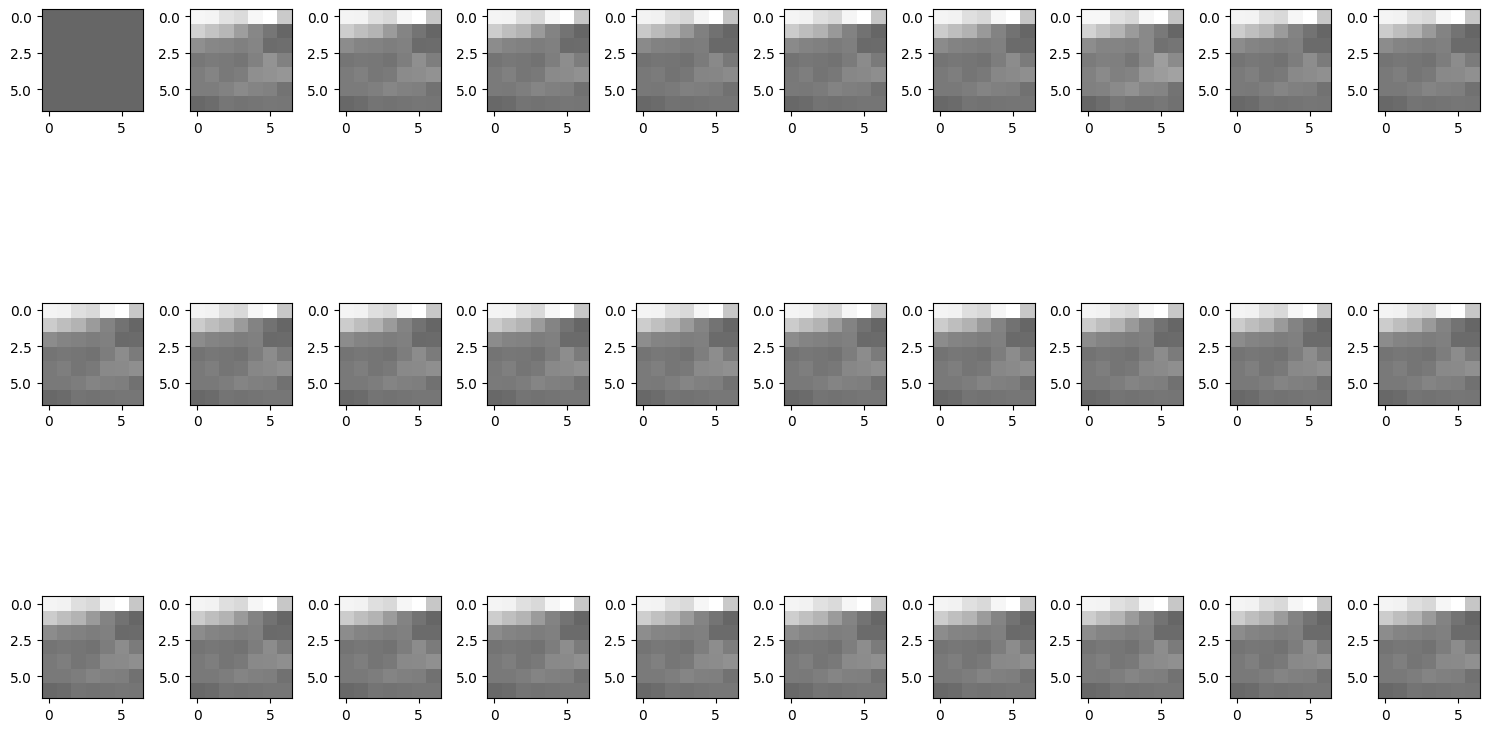

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Assuming attn_maps is a PyTorch tensor with shape [ 30,7,7]
attn_sc = attn_mapping[2].cpu()
attn_maps = attn_sc.permute(1,0)
# Reshape attn_maps to [30,(7, 7)]
attn_maps = attn_maps.view(30, 7, 7)
print(attn_maps.shape)
def plot_attention_maps( attention_map):
    fig = plt.figure(figsize=(15, 10))
    len_result = 30
    titles = []
    for i in range(len_result):
        map = attention_map[i]
        grid_size = max(int(np.ceil(len_result / 3)), 3)
        ax = fig.add_subplot(3, grid_size, i + 1)
        ax.imshow(map, cmap='gray', alpha=0.6)
    plt.tight_layout()

plot_attention_maps(attn_maps.detach().numpy())
plt.show()

torch.Size([30, 7, 7])


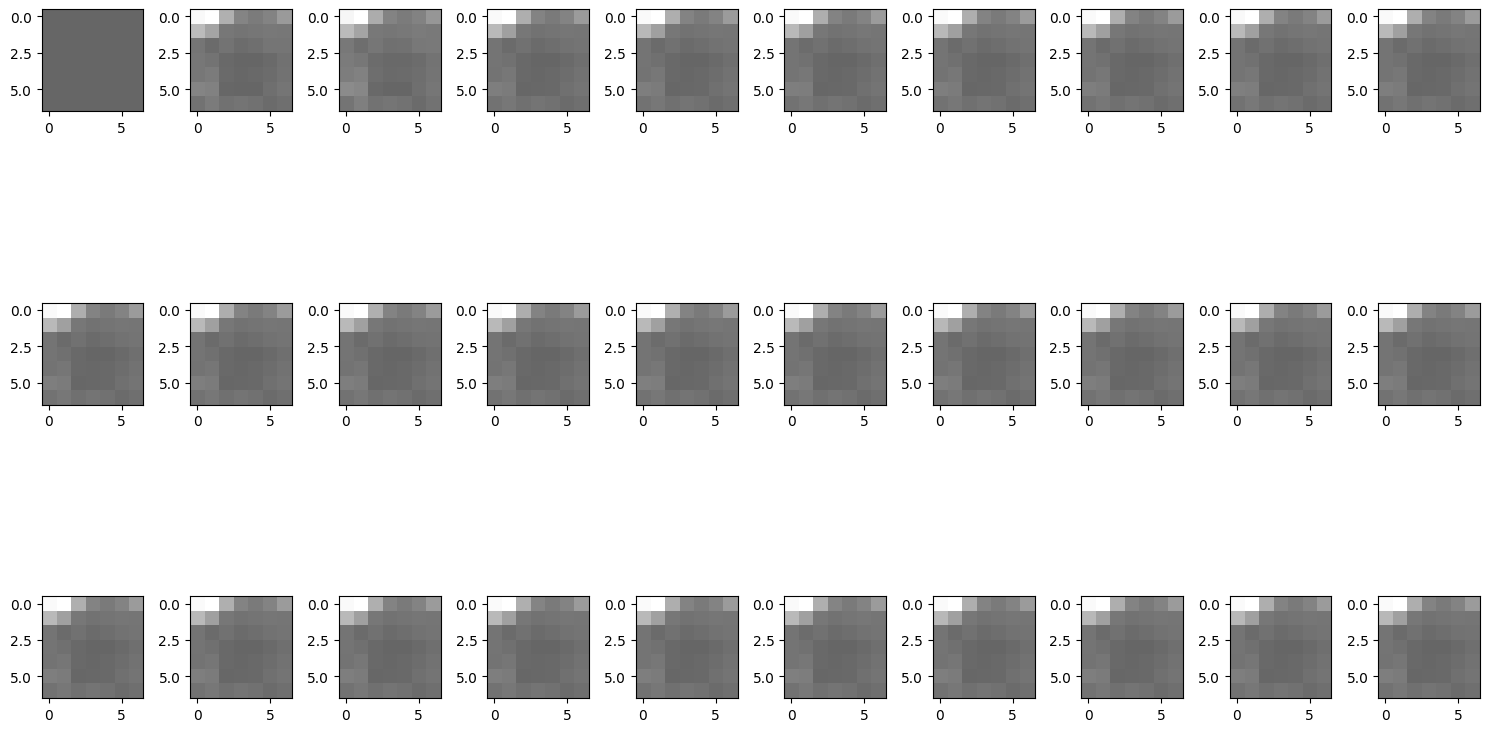

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Assuming attn_maps is a PyTorch tensor with shape [ 30,7,7]
attn_sc = attn_mapping[3].cpu()
attn_maps = attn_sc.permute(1,0)
# Reshape attn_maps to [30,(7, 7)]
attn_maps = attn_maps.view(30, 7, 7)
print(attn_maps.shape)
def plot_attention_maps( attention_map):
    fig = plt.figure(figsize=(15, 10))
    len_result = 30
    titles = []
    for i in range(len_result):
        map = attention_map[i]
        grid_size = max(int(np.ceil(len_result / 3)), 3)
        ax = fig.add_subplot(3, grid_size, i + 1)
        ax.imshow(map, cmap='gray', alpha=0.6)
    plt.tight_layout()

plot_attention_maps(attn_maps.detach().numpy())
plt.show()

In [ ]:
def loss_new(text_embeddings,image_embeddings):
        temperature = 1
        logits = (text_embeddings @ image_embeddings.T) / temperature
        print(logits)
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        print(loss)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

loss1 = loss_new(cls_embeddings, avg_attn_output)

In [ ]:
loss1 = loss_new(cls_embeddings, avg_attn_output)
loss1

tensor([[280728.6875, 280728.7500, 280728.7188, 280728.7500],
        [280728.7812, 280728.7812, 280728.8125, 280728.8125],
        [280728.6250, 280728.6250, 280728.6250, 280728.6562],
        [280728.6250, 280728.7188, 280728.6875, 280728.7188]],
       grad_fn=<DivBackward0>)
tensor([1.0280, 1.2702, 1.2685, 1.9553], grad_fn=<DivBackward0>)


tensor(1.3805, grad_fn=<MeanBackward0>)

In [ ]:
print(atth_out) #torch.Size([4, 49, 512])

tensor([[[ 10780.3604, -54271.6250, 115577.8281,  ...,  16445.3555,
           81538.1250, -56947.7188],
         [ 10780.3613, -54271.6289, 115577.8359,  ...,  16445.3555,
           81538.1250, -56947.7266],
         [ 10780.3594, -54271.6289, 115577.8047,  ...,  16445.3555,
           81538.1172, -56947.7188],
         ...,
         [ 10780.3574, -54271.6250, 115577.8281,  ...,  16445.3555,
           81538.1172, -56947.7148],
         [ 10780.3594, -54271.6250, 115577.8125,  ...,  16445.3555,
           81538.1250, -56947.7188],
         [ 10780.3613, -54271.6289, 115577.8359,  ...,  16445.3574,
           81538.1250, -56947.7266]],

        [[ 10780.3613, -54271.6328, 115577.8438,  ...,  16445.3594,
           81538.1250, -56947.7305],
         [ 10780.3613, -54271.6328, 115577.8359,  ...,  16445.3574,
           81538.1250, -56947.7305],
         [ 10780.3613, -54271.6328, 115577.8438,  ...,  16445.3574,
           81538.1328, -56947.7305],
         ...,
         [ 10780.3613, -5

In [ ]:
print(attn_weight) #attn_weight.shape - torch.Size([4, 49, 50])

tensor([[[6.1926e-03, 6.1926e-03, 6.1926e-03,  ..., 6.1926e-03,
          1.8136e-02, 1.8136e-02],
         [6.8674e-03, 6.8674e-03, 6.8674e-03,  ..., 6.8674e-03,
          1.9627e-01, 1.9627e-01],
         [6.3872e-03, 6.3872e-03, 6.3872e-03,  ..., 6.3872e-03,
          1.2545e-01, 1.2545e-01],
         ...,
         [6.5891e-03, 6.5891e-03, 6.5891e-03,  ..., 6.5891e-03,
          8.2102e-02, 8.2102e-02],
         [6.8075e-03, 6.8075e-03, 6.8075e-03,  ..., 6.8075e-03,
          3.1145e-02, 3.1145e-02],
         [5.8785e-03, 5.8785e-03, 5.8785e-03,  ..., 5.8785e-03,
          5.8785e-03, 5.8785e-03]],

        [[1.9291e-02, 1.9291e-02, 1.1526e-02,  ..., 1.9291e-02,
          1.4107e-01, 1.8391e-02],
         [1.1604e-02, 1.1604e-02, 3.6521e-03,  ..., 1.1604e-02,
          4.0117e-01, 1.2931e-01],
         [1.9084e-02, 1.9084e-02, 5.3491e-03,  ..., 1.9084e-02,
          2.3448e-01, 5.8687e-04],
         ...,
         [1.5885e-02, 1.5885e-02, 4.7142e-03,  ..., 1.5885e-02,
          3.564

In [ ]:
batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))
print(out)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
tensor([[253.2870,  25.3080,  15.6998,  16.5406],
        [ 25.3080, 237.9690,  29.5491,  23.5128],
        [ 15.6998,  29.5491, 257.6260,  -4.1907],
        [ 16.5406,  23.5128,  -4.1907, 288.5559]])


In [11]:
import torch
from torch.nn import functional as F

def contrastive_loss(txt_embedding, img_embedding, margin=1.0, temperature=0.5):
  """
  Calculates Contrastive Loss for text and image pairs.

  Args:
    txt_embedding: Tensor of shape (batch_size, embedding_dim) - Text embeddings.
    img_embedding: Tensor of shape (batch_size, embedding_dim) - Image embeddings.
    margin: Float - Margin parameter for contrastive loss.
    temperature: Float - Temperature parameter for softmax normalization.

  Returns:
    Tensor of shape (batch_size,) - Contrastive loss for each pair.
  """

  # Compute pairwise cosine similarities
  similarities = F.cosine_similarity(txt_embedding, img_embedding)
  print(similarities)
  # Create positive and negative mask
  pos_mask = torch.eye(txt_embedding.size(0), device=txt_embedding.device).bool()
  neg_mask = ~pos_mask


  # Compute positive and negative logits
  pos_logits = similarities / temperature
  print(pos_logits.shape)
  neg_logits = torch.logsumexp(similarities * neg_mask, dim=1, keepdim=True) / temperature
  print(neg_logits.shape)
  # Compute contrastive loss
  loss = torch.mean(pos_logits + margin - neg_logits)

  # Return average loss for each pair
  return loss

# Example usage
batch_size = 4
embedding_dim = 512

txt_embedding = torch.randn(batch_size, embedding_dim)
img_embedding = torch.randn(batch_size, embedding_dim)

loss = contrastive_loss(txt_embedding, img_embedding)

print(f"Contrastive Loss: {loss:.4f}")


tensor([ 0.0580, -0.0045,  0.0260,  0.0038])
torch.Size([4])
torch.Size([4, 1])
Contrastive Loss: -1.7627
